In [1]:
%load_ext autoreload
%autoreload 2
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# --- 1. Import Custom Function Modules ---
from pathlib import Path
# Locate the project root directory named "student_t_mle" among cwd ancestors (fallback to a known path)
def find_parent_dir_named(name='student_t_mle'):
    p = Path.cwd().resolve()
    if p.name == name:
        return p
    for anc in p.parents:
        if anc.name == name:
            return anc
    known = Path('/Users/antoineluciano/Documents/Recherche/student_t_mle')
    if known.exists():
        return known
    raise FileNotFoundError(f"Could not find parent dir named '{name}' in cwd ancestors or fallback path.")

parent_dir = find_parent_dir_named('student_t_mle')
os.chdir(parent_dir)
try: 
    import jax_gibbs as gs_jax
except ImportError:
    print("Error: Make sure 'jax_gibbs.py' is in the same directory.")
try: 
    import sampler_functions as sf 
except ImportError:
    print("Error: Make sure 'sampler_functions.py' is in the same directory.")
try: 
    import utils 
except ImportError:
    print("Error: Make sure 'utils.py' is in the same directory.")

In [8]:
ks = [1.0, 2.0, 5.0]
m = 10 
mu = 2.0
T_jax = 10000
T_np = 10000
T_kde = 10000
import jax.random as random
import time
params = {
        'm': m,
        'k': None,  # to be set in the loop
        'mu_true': mu, 
        'num_iterations_T': None,  # to be set in the loop
        'prior_mean': 0.0,
        'prior_std': 10.0,
        'proposal_std_mu': 0.9,
        'proposal_std_z': 0.03,
    }

key = random.PRNGKey(0)
mus_jax = {}
mus_np = {}
true_posteriors = {}
times_jax = {}
times_np = {}
times_kde = {}
for k in ks:
    print(f"Processing k={k}")
    print("Generating data...")
    params['k'] = k
    key, subkey = random.split(key)
    data = random.t(subkey, df=k, shape=(m,)) + mu
    mle = utils.get_mle(data, params)
    print(f"Running JAX Gibbs sampler for k={k}, m={m}...")
    t0 = time.time()
    params['num_iterations_T'] = T_jax
    gibbs_norm_jax = gs_jax.run_gibbs_sampler_mle_jax(key, mle, params)
    times_jax[k] = time.time() - t0
    mus_jax[k] = gibbs_norm_jax['mu_chain']
    
    print(f"Running NumPy Gibbs sampler for k={k}, m={m}...")
    params['num_iterations_T'] = T_np
    params["mu_star"] = mle
    params["z_domain"] = (-1/(2*np.sqrt(k)), 1/(2*np.sqrt(k)))
    x0 = np.ones(m) * mle
    mu0 = mle
    t0 = time.time()
    gibbs_norm_np = sf.run_main_gibbs_sampler(params, mu0, x0)
    times_np[k] = time.time() - t0
    mus_np[k] = gibbs_norm_np['mu_chain']
    
    print(f"Estimating true posterior with KDE for k={k}, m={m}...")
    t0 = time.time()
    true_posteriors[k] = utils.get_normalized_posterior_mle_pdf(mle, params, num_simulations=T_kde)
    times_kde[k] = time.time() - t0
    print("Done.\n")
    

Processing k=1.0
Generating data...
Running JAX Gibbs sampler for k=1.0, m=10...


Running Gibbs Sampler: 100%|██████████| 10000/10000 [00:25<00:00, 394.48it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.3986
Z_i Acceptance Rate: 0.7499
Running NumPy Gibbs sampler for k=1.0, m=10...

--- Starting the Main Gibbs Sampler ---


Running Gibbs Sampler: 100%|██████████| 9999/9999 [00:51<00:00, 192.88it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4054
Z_i Acceptance Rate: 0.8052
Estimating true posterior with KDE for k=1.0, m=10...

--- Computing Benchmark KDE from 10000 simulations ---
(This is computationally intensive and will take some time...)
  Processing simulation 10000/10000...
Processing k=2.0
Generating data...
Running JAX Gibbs sampler for k=2.0, m=10...


Running Gibbs Sampler: 100%|██████████| 10000/10000 [00:19<00:00, 513.58it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4509
Z_i Acceptance Rate: 0.6788
Running NumPy Gibbs sampler for k=2.0, m=10...

--- Starting the Main Gibbs Sampler ---


Running Gibbs Sampler: 100%|██████████| 9999/9999 [00:53<00:00, 186.53it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4325
Z_i Acceptance Rate: 0.7405
Estimating true posterior with KDE for k=2.0, m=10...

--- Computing Benchmark KDE from 10000 simulations ---
(This is computationally intensive and will take some time...)
  Processing simulation 10000/10000...
Processing k=5.0
Generating data...
Running JAX Gibbs sampler for k=5.0, m=10...


Running Gibbs Sampler: 100%|██████████| 10000/10000 [00:18<00:00, 534.21it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4379
Z_i Acceptance Rate: 0.7501
Running NumPy Gibbs sampler for k=5.0, m=10...

--- Starting the Main Gibbs Sampler ---


Running Gibbs Sampler: 100%|██████████| 9999/9999 [00:51<00:00, 195.42it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4280
Z_i Acceptance Rate: 0.8223
Estimating true posterior with KDE for k=5.0, m=10...

--- Computing Benchmark KDE from 10000 simulations ---
(This is computationally intensive and will take some time...)
  Processing simulation 10000/10000...


In [9]:
for k in ks:
    print(f"Timings for k={k}, m={m}:")
    print(f"  JAX Gibbs sampler time: {times_jax[k]:.2f} seconds")
    print(f"  NumPy Gibbs sampler time: {times_np[k]:.2f} seconds")
    print(f"  KDE estimation time: {times_kde[k]:.2f} seconds")
    print()

Timings for k=1.0, m=10:
  JAX Gibbs sampler time: 25.36 seconds
  NumPy Gibbs sampler time: 51.84 seconds
  KDE estimation time: 1.99 seconds

Timings for k=2.0, m=10:
  JAX Gibbs sampler time: 19.52 seconds
  NumPy Gibbs sampler time: 53.61 seconds
  KDE estimation time: 3.34 seconds

Timings for k=5.0, m=10:
  JAX Gibbs sampler time: 18.74 seconds
  NumPy Gibbs sampler time: 51.17 seconds
  KDE estimation time: 2.18 seconds



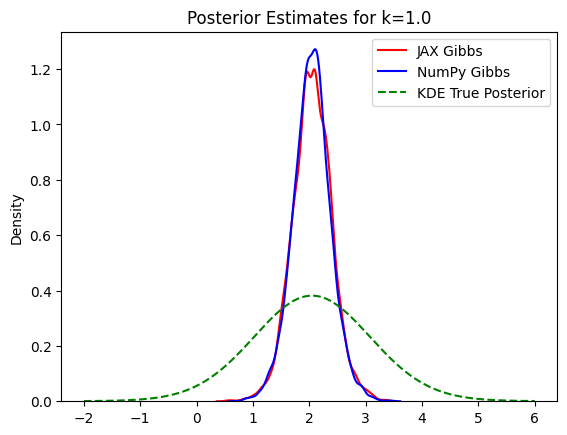

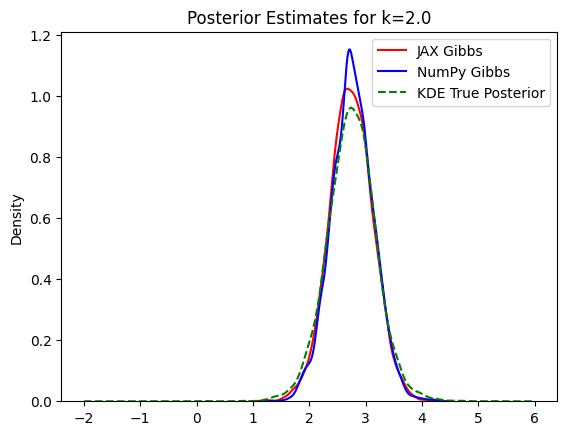

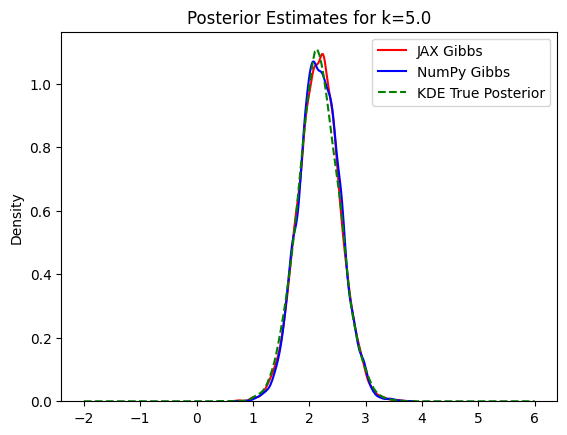

In [10]:
for k in ks:
    sns.kdeplot(mus_jax[k], label=f'JAX Gibbs', color = "red") 
    sns.kdeplot(mus_np[k], label=f'NumPy Gibbs', color = "blue")
    mus = np.linspace(mu - 4, mu + 4, 200)
    plt.plot(mus, true_posteriors[k](mus), label='KDE True Posterior', color = "green", linestyle='--')
    plt.title(f'Posterior Estimates for k={k}')
    plt.legend()
    plt.show()

# What is failing when $k = 1$?

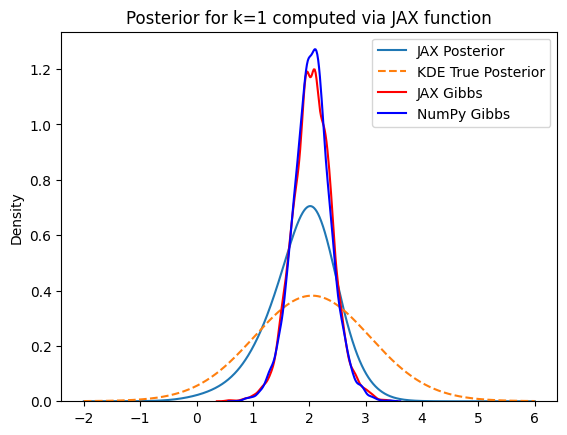

In [ ]:
k = 1
key = random.PRNGKey(0)
x = random.t(key, df=k, shape=(m,)) + mu

import jax.numpy as jnp
mus = np.linspace(-2, 6, 1000)
posterior_logpdf = gs_jax.unnormalized_posterior_mu_logpdf_jax(mus, x, prior_loc=0.0, prior_scale=10.0, k=k)
posterior_pdf = jnp.exp(posterior_logpdf)
plt.plot(mus, posterior_pdf/jnp.trapezoid(posterior_pdf, mus), label='JAX Posterior')
plt.plot(mus, true_posteriors[k](mus), label='KDE True Posterior', linestyle='--')
sns.kdeplot(mus_jax[k], label=f'JAX Gibbs', color = "red")
sns.kdeplot(mus_np[k], label=f'NumPy Gibbs', color = "blue")
plt.legend()
plt.title(f'Posterior for k={k} computed via JAX function')
plt.show()


    

Text(0.5, 1.0, 'Posterior for k=1 computed via manual JAX function')

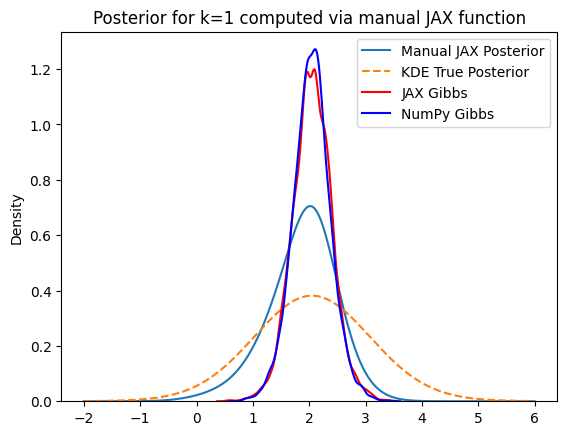

In [17]:
from jax.scipy.stats import t, norm
from jax import jit, vmap
def logpdf(mu, x, k): 
    # Likelihood
    log_likelihood = jnp.sum(t.logpdf(x -mu, df=k))
    # Prior
    log_prior = norm.logpdf(mu, loc=0.0, scale=10.0)
    
    return log_likelihood + log_prior
logpdf_batch = vmap(logpdf, in_axes=(0, None, None))
mus = np.linspace(-2, 6, 1000)
posterior_logpdf = logpdf_batch(mus, x, k)
posterior_pdf = jnp.exp(posterior_logpdf)
plt.plot(mus, posterior_pdf/jnp.trapezoid(posterior_pdf, mus), label='Manual JAX Posterior')
plt.plot(mus, true_posteriors[k](mus), label='KDE True Posterior', linestyle='--')
sns.kdeplot(mus_jax[k], label=f'JAX Gibbs', color = "red")
sns.kdeplot(mus_np[k], label=f'NumPy Gibbs', color = "blue")
plt.legend()
plt.title(f'Posterior for k={k} computed via manual JAX function')